# Exploration 노드 15
## 라이브러리 불러오기

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

## 1) 검증용 데이터셋 준비

In [2]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images/'

images = glob(work_dir+'*')
images.sort()
images

['/aiffel/aiffel/ocr_python/images/image1.jpeg',
 '/aiffel/aiffel/ocr_python/images/image10.jpg',
 '/aiffel/aiffel/ocr_python/images/image11.jpeg',
 '/aiffel/aiffel/ocr_python/images/image12.jpg',
 '/aiffel/aiffel/ocr_python/images/image13.jpg',
 '/aiffel/aiffel/ocr_python/images/image14.png',
 '/aiffel/aiffel/ocr_python/images/image15.png',
 '/aiffel/aiffel/ocr_python/images/image2.png',
 '/aiffel/aiffel/ocr_python/images/image3.jpg',
 '/aiffel/aiffel/ocr_python/images/image4.jpg',
 '/aiffel/aiffel/ocr_python/images/image5.jpg',
 '/aiffel/aiffel/ocr_python/images/image6.jpg',
 '/aiffel/aiffel/ocr_python/images/image7.jpeg',
 '/aiffel/aiffel/ocr_python/images/image8.jpg',
 '/aiffel/aiffel/ocr_python/images/image9.jpg']

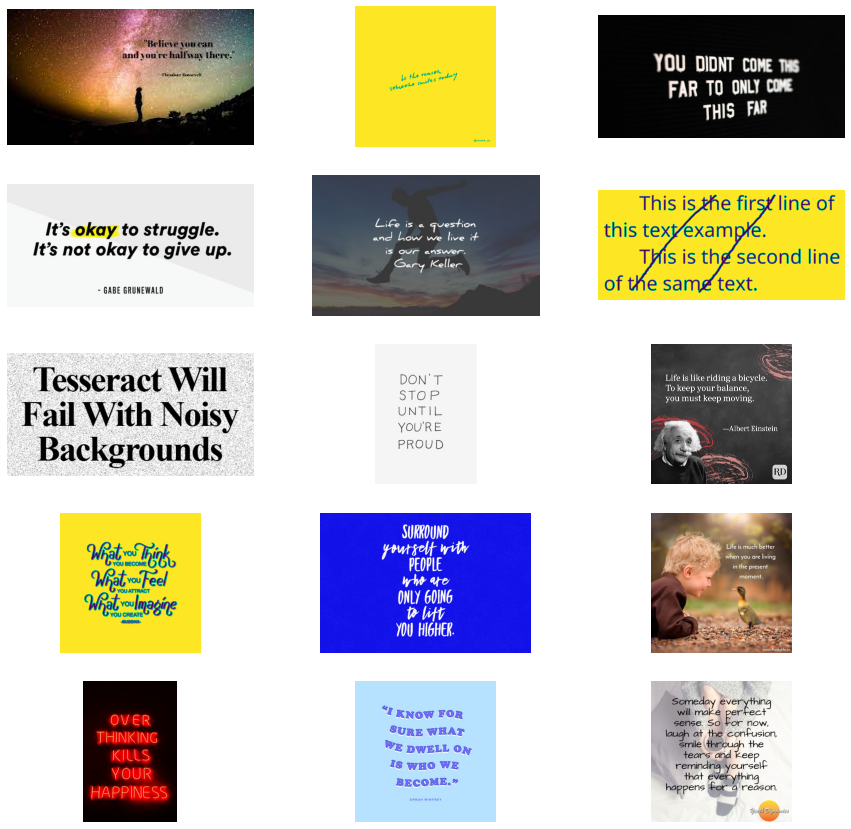

In [3]:
plt.figure(figsize=(15,15))

for idx, im in enumerate(images):
    plt.subplot(5, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

데이터셋의 사진들 속의 텍스트가 글씨체, 배치, 노이즈의 유무 모두 다양하게 구성되도록 준비하였다. 

## 2) 테스트 진행
### keras-ocr

In [4]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images_keras = [ keras_ocr.tools.read(image) for image in images]
prediction_groups = [pipeline.recognize([image]) for image in images]

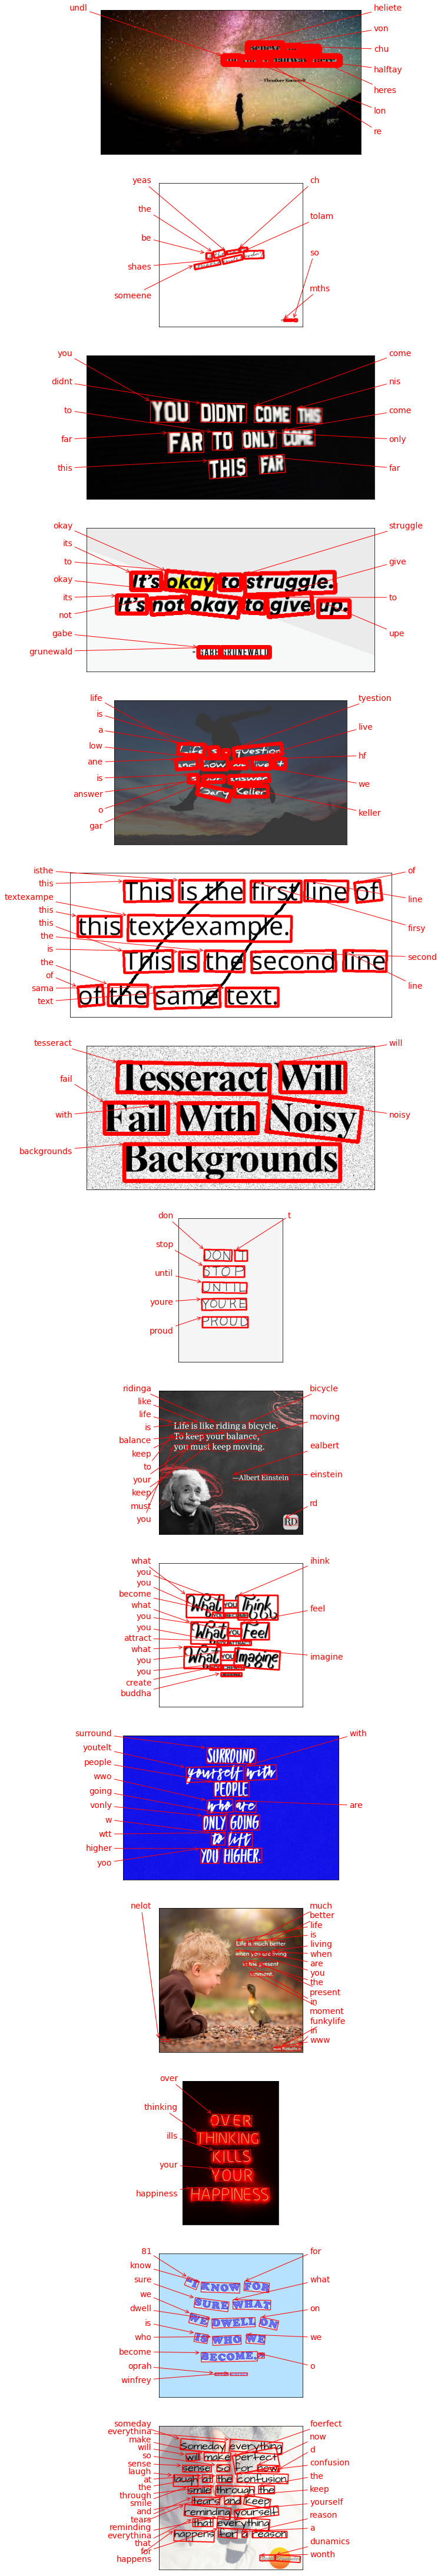

In [8]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(80, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

영어 필기체의 경우에는 정확도가 떨어지는 것을 확인하였다. 또한 화질이 낮아지거나, 글에 줄이 그어진 것과 같이 노이즈가 심한 사진에도 해당 부분에서 정확도가 떨어졌다. 단어들의 배치가 일직선이 아니어도 각 단어는 잘 인식한 것으로 보인다. 즉 Detect하는 것은 매우 정확하지만, Recognize하는 부분에서는 조금 부족하다. 

### Tesseract

In [9]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [16]:
cropped_images = []
for idx, image in enumerate(images):
    cropped_images.append(crop_word_regions(image, "".join([work_dir, 'tesseract/', str(idx)])))

/aiffel/aiffel/ocr_python/images/tesseract/0/0000.png
/aiffel/aiffel/ocr_python/images/tesseract/1/0000.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0000.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0001.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0002.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0003.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0004.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0005.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0006.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0007.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0008.png
/aiffel/aiffel/ocr_python/images/tesseract/2/0009.png
/aiffel/aiffel/ocr_python/images/tesseract/3/0000.png
/aiffel/aiffel/ocr_python/images/tesseract/3/0001.png
/aiffel/aiffel/ocr_python/images/tesseract/3/0002.png
/aiffel/aiffel/ocr_python/images/tesseract/3/0003.png
/aiffel/aiffel/ocr_python/images/tesseract/3/0004.png
/aiffel/aiffel/ocr_python/images/tesseract/3/0005.png
/aiffel/aiffel/ocr_python/im

In [17]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")


In [18]:
for cropped_image in cropped_images:
    recognize_images(cropped_image)


Done
tes td

Done
YOU DIDNT

NT

:

FAR

re


wid

7



Done
It’s

oka}

TO

struggle.

It’s

not

okay

TO

give

Up.

ia

bAKE

HRUNE WALL

Done
Rope a

_

—s

question

anc

Lee,

vA

er

Po

.

ol) as

ae ed)

ae EO ae

Done
- vt > Z O : .

Done
oe

‘Tesseract

Will


Fail

With

Noisy


Backgrounds


Done
DON

7

STOP

LIN T IE

YOURE

PROUD

Done

=


a

5

-

Life 1s

like riding a

ee Se

ie

Keep

YOUL

balance,

My4e 8

MUST

eral @

moving.


Done
wee

Done
UT)

alg

Vai

f

Ue

Y 60


be tt


Done


| |

eis mucl

better

when

Ae) 8

are

living

In

the

present

moment.

Done
OV EIR

THINKING

KILLS

WAGER

HAPPINESS

Done
“SF

KN Ow

FOR

SURE

WHAP,T

Wr

DWELL

ON

IS

w HO

W E

BECOME.”

PRAH


Done
Someday

everything

will

make

errt-ect

SeEMnse.

SO

Ot

NIOW,

laugr

Ort

the

contusion,

Smile

throudch

the

Tears

ond

Ce

r

처참한 결과다. Tesseract는 텍스트 인식조차 하지 못한 사진이 여러 장이며, 인식을 한 경우에도 단어 단위로 하지 못했다. 단어 단위로 인식한 드문 경우에도 위에서 볼 수 있듯이 정확도가 너무 떨어진다. 사실상 Tesseract는 이정도면 사용이 불가능하다고 봐야 한다. 한가지 웃긴 점이 있다면, Tesseract는 노이지한 데이터에서 실패한다는 내용의 사진에서 오히려 비교적으로 가장 정확한 성능을 발휘하였다. 그외에는 정말 성능이 너무 떨어진다는 것을 확인할 수 있었다..

## 4) 결과 분석과 결론 제시

__서비스 내용과 목적__:
OCR은 다양한 방법으로 활용이 가능한 기술이다. 이미 사용되는 사례이지만, 이번 노드에서 회원가입 및 본인 인증 과정에서 신분증을 촬영하면 개인정보를 인식하여 이름, 생년월일 등의 항목을 인식하여 해당 항목을 자동으로 채워주는 서비스를 만든다고 가정하자.  

__평가 기준 선정__:
이러한 서비스를 이미 사용해본 사람이라면 알고 있겠지만, 신분증을 촬영할 때 주민등록증 또는 운전면허와 같이 카드의 크기에 맞게 촬영을 하도록 설정이 된다. 이렇게 촬영하는 칸의 크기를 지정한다고 가정하면 개인정보의 위치는 사실상 정해져 있다고 생각해도 무방하다. 이런 상황에서는 인식하는 텍스트의 위치는 예측이 가능하기 때문에 텍스트를 인식하는 Detect하는 기능은 중요성이 좀 떨어지고, 오히려 개인정보는 민감한 내용이기 때문에 OCR을 활용하여 텍스트를 정확하게 Recognize하는 것이 핵심이다. 그렇기 때문에 인식한 글의 인식 정확성을 평가 기준으로 하겠다.  

__결론__:
keras-ocr과 Tesseract 두 모델 중 하나를 골라야 하는 상황인데, 너무 쉬운 결정이다. Detect나 Recognize나 두 부분 모두에서 keras-ocr이 우위에 있기 때문이다. keras-ocr은 정확성 측면에 있어서 노이즈가 심한 경우에는 좀 떨어지게 되지만, 웬만하면 정확하게 글씨를 인식한다. 하지만 Tesseract의 경우, 노이즈가 심하지 않더라도 그냥 기본적으로 정확성이 떨어진다. 위에서 볼 수 있듯이 Tesseract는 처음부터 끝까지 정확하게 인식한 사진이 없다. 두 모델 중 하나를 사용한다면 무조건 keras-ocr를 사용할 것이다.

# 회고

* 이번 노드에서 OCR의 개념에 대해 배우고, 다양한 종류의 OCR 기술을 활용해볼 수 있었다. 한 가지 아쉬운 부분이 있다면, 이번 노드에서는 미리 구축되어 있는 라이브러리를 불러와서 사용했다는 점에서, 직접 OCR를 구현하거나 기술을 자세하기까지는 알아보지 않았다는 것이다. OCR은 CNN, RNN 다양하게 기술들을 혼합하여 구현한 기술 같은데, 이에 대해 더 자세하게 공부해보고 싶다. 
* OCR의 기술에 어떤 종류들이 더 있는지 궁금하다. 오늘 사용해본 기술들 중 구글은 조금 괜찮았지만 keras-ocr 또는 Tesseract는 확실히 성능이 요즘에 실제로 사용되는 기술들보다 떨어질 것이 분명하다. 
* 이번 노드는 여태까지 해온 노드들과는 조금 다른 느낌이다. 지금까지는 다양한 모델들을 구현해보고 학습해서 응용하는 느낌이어더라면, 이번 노드는 있는 기술을 간단하게 체험해보는 느낌이었다.
* 제출 직전에 막 열심히 해서 제출했는데, 다음부터는 미리미리 해야겠다. 